In [2]:
import os
import sys
sys.path.append(r"C:\Users\Cristhian\Documents\github\QuantumGRN")
import numpy as np
import pandas as pd

In [3]:
filename="../../dataset/expr_matrix_pearsonresidual_7.txt"
df = pd.read_csv(filename, delimiter='\t')
df = df.set_index('genes').T
df.head()

genes,AICDA,IRF4,PAX5,PRDM1,REL,RELA
X1,-0.744255,-1.389371,0.869163,-0.639366,0.499583,-0.558294
X2,-0.574980,0.760179,1.470277,-0.493802,0.178566,-0.431103
X3,-0.756529,0.670392,5.327456,-0.649925,1.276864,1.188840
X4,1.000327,-1.152912,-0.541244,-0.529274,0.039775,-0.462092
X5,-0.505078,-0.946417,-0.443544,-0.433726,-0.800315,-0.378630


In [22]:
df.describe()

genes,IRF4,REL,PAX5,RELA,PRDM1,AICDA
count,28208.000000,28208.000000,28208.000000,28208.000000,28208.000000,28208.000000
mean,-0.029013,0.018002,-0.014341,0.004746,0.049356,0.021640
std,1.815796,1.940658,1.125635,1.016335,1.566395,2.334047
min,-2.896077,-2.390919,-1.407811,-1.297434,-1.482664,-1.671623
25%,-1.214902,-1.114657,-0.705850,-0.624455,-0.755748,-0.885706
50%,-0.639464,-0.696006,-0.533796,-0.479041,-0.581310,-0.697969
75%,0.604844,0.533787,0.487246,0.543907,0.299984,-0.475637
max,32.874451,38.653309,10.090692,7.839622,25.800115,33.609311


In [4]:
from qscgrn import *

ncells, ngenes = df.shape
df = qsc_order_gene(df)
genes = df.columns.to_list()
p_obs = qsc_distribution(df)
activation = qsc_activation_ratios(df)

2024-07-05 14:17:11 | I | The dataframe genes are ordered
2024-07-05 14:17:11 | I | The observed probability `p_obs` is calculated
2024-07-05 14:17:11 | I | Activation ratios are computed


2024-07-05 14:17:11 | I | Plotting the Observed distribution in a barplot and exporting to p_obs.svg file.


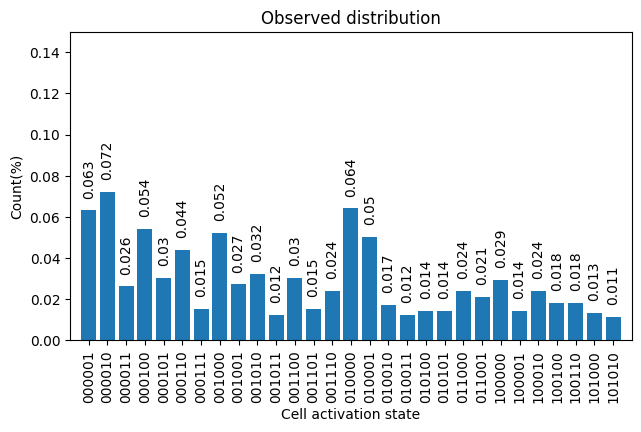

In [5]:
mask = mini_hist(ngenes, p_obs, limit=0.01, ymax=0.15,
                 title="Observed distribution",
                 filename="p_obs.svg")

In [6]:
theta = theta_init(genes, activation_ratios=activation)
edges = edges_init(genes)
qgrn = model(ncells, genes, theta, edges, p_obs, epochs=4000, learning_rate=0.05, save_theta=True)

2024-07-05 14:17:11 | I | Theta series is initialized using zeros as method with activation values
2024-07-05 14:17:11 | I | Edges for the QuantumGRN and quantum circuit are created for 6 genes
2024-07-05 14:17:11 | I | The QuantumGRN model is been initialized with 6 genes and 28208 cells


In [7]:
p_init = qgrn.output_probabilities(drop_zero=True).reshape(2**ngenes,)

2024-07-05 14:17:11 | I | Plotting the Comparison of distributions in a barplot and exporting to comparison_obs_init.svg file.


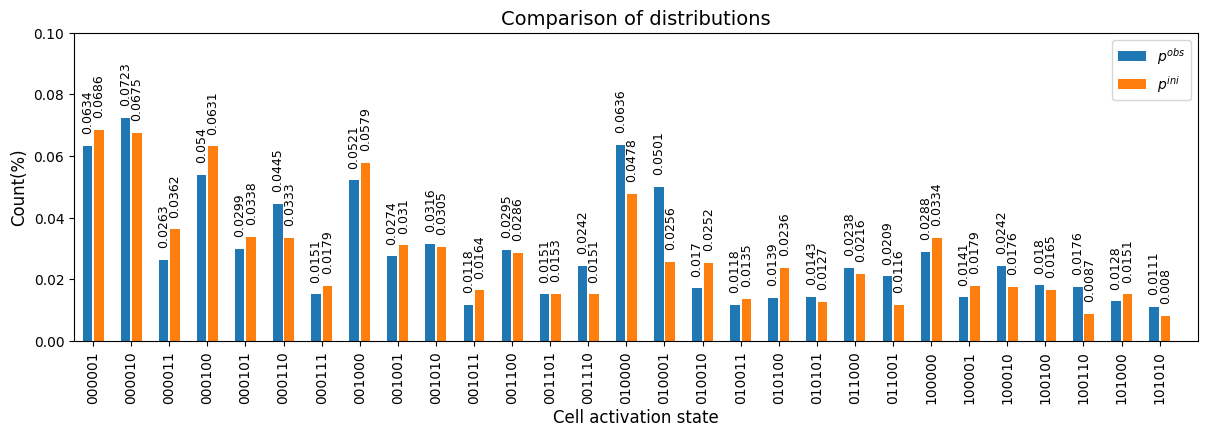

In [8]:
comparison_hist(ngenes, p_obs, p_init, limit=0.01, ymax=0.10, mask=mask,
                filename="comparison_obs_init.svg", tags=["p^{obs}", "p^{ini}"])

In [9]:
qgrn.train()

2024-07-05 14:17:12 | I | Starting the optimization for the QuantumGRN
1049/4000 [============>.....................................] - 64s 61ms/step
2024-07-05 14:18:17 | I | Optimization completed!!.. Due to threshold reached


In [10]:
p_out = qgrn.p_out.reshape(2**ngenes,)

2024-07-05 14:18:17 | I | Plotting the Comparison of distributions in a barplot and exporting to comparison_obs_out.svg file.


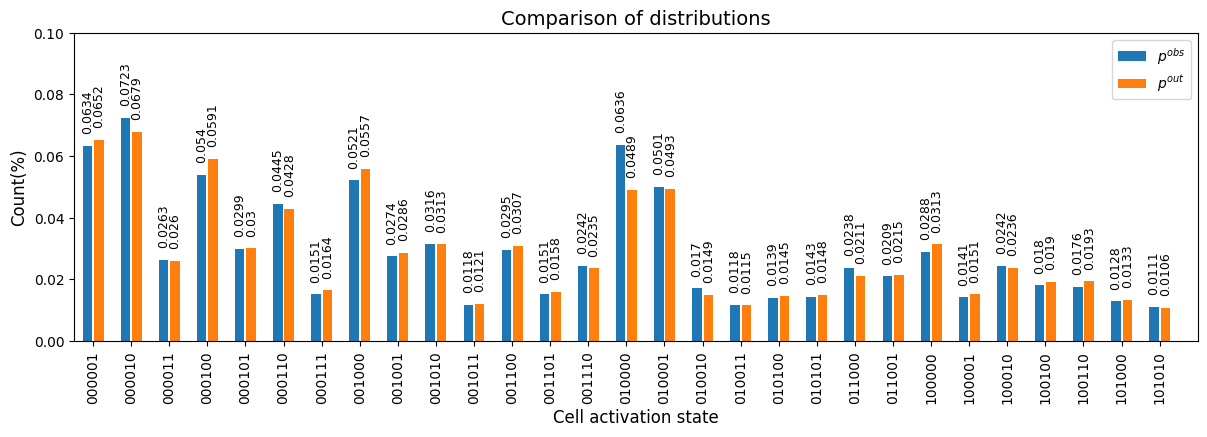

In [11]:
comparison_hist(ngenes, p_obs, p_out, limit=0.01, ymax=0.10, mask=mask,
                filename="comparison_obs_out.svg")

In [12]:
p_qiskit = qgrn.run_qiskit(filename="circuit_qscgrn.svg")

2024-07-05 14:18:20 | I | Drawing the quantum circuit of the qscGRN model and saving to circuit_qscgrn.svg


2024-07-05 14:18:20 | I | Plotting the Comparison of distributions in a barplot and exporting to comparison_obs_qiskit.svg file.


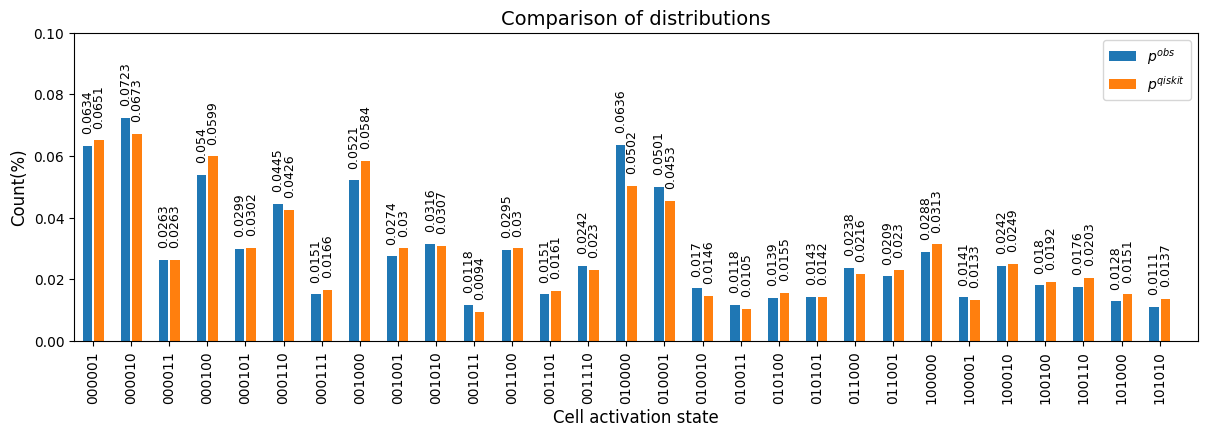

In [13]:
comparison_hist(ngenes, p_obs, p_qiskit, limit=0.01, ymax=0.1, mask=mask,
                filename="comparison_obs_qiskit.svg", tags=["p^{obs}", "p^{qiskit}"])

In [14]:
qgrn.export_training_theta("evolution_theta.csv")

2024-07-05 14:18:21 | I | Theta values during optimization are exported to evolution_theta.csv


In [15]:
from qscgrn import draw_network

draw_network(genes, edges, qgrn.theta, filename="network_qscgrn.svg")

2024-07-05 14:18:21 | I | Drawing the network representation of the qscGRN model and exporting to network_qscgrn.svg file.


In [16]:
import matplotlib as mpt
import matplotlib.pyplot as plt

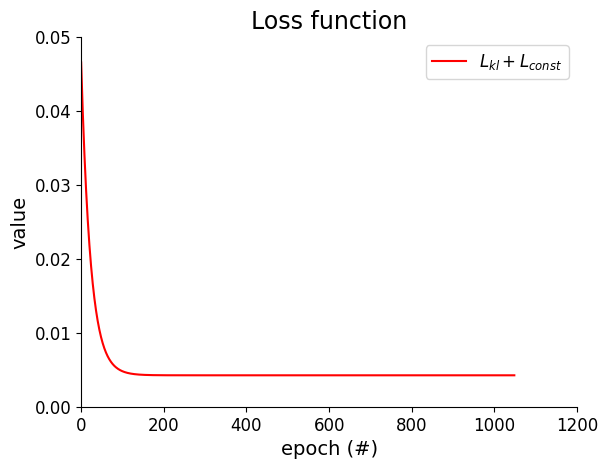

In [17]:
plt.figure()
plt.plot(qgrn.loss, 'r', label='$L_{kl} + L_{const}$')

plt.title("Loss function", fontsize=17)
plt.xlabel("epoch (#)", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200], fontsize=12)
plt.yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05], fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(fontsize=12)
plt.xlim([0, 1200])
plt.ylim([0, 0.05])

plt.savefig("loss_function.svg", transparent=True, bbox_inches="tight", facecolor ='w', dpi=700)

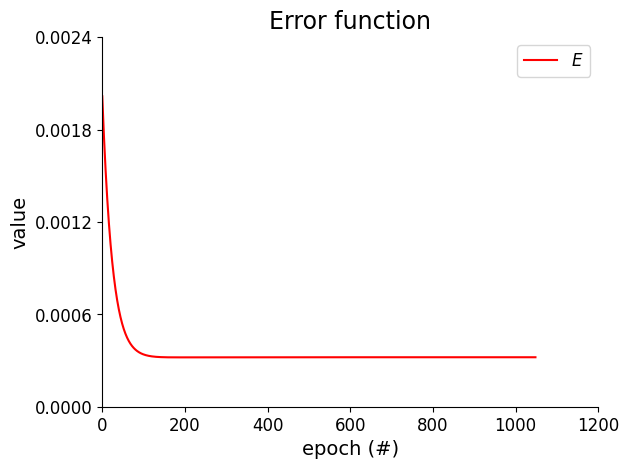

In [18]:
plt.figure()
plt.plot(qgrn.error, 'r', label='$E$')

plt.title("Error function", fontsize=17)
plt.xlabel("epoch (#)", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.xticks([0, 200, 400, 600, 800, 1000, 1200], fontsize=12)
plt.yticks([0, 0.0006, 0.0012, 0.0018, 0.0024], fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(fontsize=12)
plt.xlim([0, 1200])
plt.ylim([0, 0.0024])

plt.savefig("error_function.svg", transparent=True, bbox_inches="tight", facecolor ='w', dpi=700)

In [24]:
print(p_obs)
print(p_out)
print(p_qiskit)

[0.         0.06343644 0.07233768 0.02634123 0.0540116  0.02988561
 0.04446593 0.01510391 0.0520783  0.02738843 0.03161753 0.01176092
 0.02952312 0.01506364 0.02420654 0.00874013 0.06355727 0.05010472
 0.01695666 0.01176092 0.01385532 0.0142581  0.00604157 0.0047527
 0.02380377 0.02090382 0.00656517 0.00571935 0.00692766 0.00813598
 0.00265829 0.00289995 0.02875785 0.01409699 0.02420654 0.00785404
 0.01804414 0.0075721  0.01764137 0.00688739 0.0128484  0.00592073
 0.01111648 0.00374577 0.00906235 0.0042291  0.00906235 0.00382633
 0.00761237 0.00801514 0.00302078 0.00350411 0.00366522 0.00398743
 0.0022958  0.00217496 0.00285967 0.00382633 0.00136942 0.00144998
 0.00205413 0.00205413 0.00136942 0.00100693]
[0.         0.06521254 0.06794768 0.0259732  0.05908685 0.0300497
 0.04279956 0.01640307 0.05565237 0.02857475 0.03129687 0.01207035
 0.03074612 0.01575461 0.02345866 0.00906406 0.04887376 0.04934504
 0.01491906 0.01151062 0.01448308 0.01482083 0.00614806 0.00491858
 0.02110899 0.0214

In [19]:
with open("results/p_obs.npy", "wb") as f:
    np.save(f, p_obs)
    
with open("results/p_out.npy", "wb") as f:
    np.save(f, p_out)
    
with open("results/p_qiskit.npy", "wb") as f:
    np.save(f, p_qiskit)

In [20]:
with open("results/loss.npy", "wb") as f:
    np.save(f, qgrn.loss)
    
with open("results/error.npy", "wb") as f:
    np.save(f, qgrn.error)

In [21]:
qgrn.theta.to_csv("results/theta.csv")